# Импортируем библиотеки

In [ ]:
!pip install yfinance --upgrade
!pip install pandas matplotlib

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
from tqdm.notebook  import tqdm
import yfinance as yf
import datetime as dt
import math
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Создаем датасет

Ниже функция для заданного тикера и дня находит информацию о стоимости акции на моменты времени: месяц до даты, две недели до даты, неделя до даты, день до даты, день даты, и те же промежутки после даты

In [ ]:
def GetTickerCost(ticker, tradeDay):
    data = yf.download(
        ticker,
        start=(tradeDay - relativedelta(months=1)).strftime("%Y-%m-%d"),
        end=(tradeDay + relativedelta(months=1) + timedelta(7)).strftime("%Y-%m-%d"),
        progress=False
    )
    if data.shape[0] == 0:
        return [float('nan')] * 10

    interestingDates = [
        tradeDay - relativedelta(months=1),
        tradeDay - relativedelta(weeks=2),
        tradeDay - relativedelta(weeks=1),
        tradeDay - relativedelta(days=1),
        tradeDay - relativedelta(days=0),
        tradeDay + relativedelta(days=1),
        tradeDay + relativedelta(weeks=1),
        tradeDay + relativedelta(weeks=2),
        tradeDay + relativedelta(months=1),
    ]
    index = 0
    result = []

    for date in data.index:
        if index == len(interestingDates):
            return result

        while index < len(interestingDates) and date.date() >= interestingDates[index]:
            result.append(float(data.loc[date]["Close"]))

            if index == 4:
                result.append(float(data.loc[date]["Volume"]))
            index += 1

    result += [float('nan')] * (len(interestingDates) + 1 - len(result))

    return result

Ниже функция находит данные по заданному промежутку дней о том, какие операции были совершены и собирает датасет

In [ ]:
def LoadInsidersInfo(startDate, endDate, maxPages=100):
    BASE_URL = "http://openinsider.com/screener?s=&o=&pl=&ph=&ll=&lh=&fd=-1&td=0&tdr=&fdlyl=&fdlyh=&daysago=&xp=1&xs=1&vl=&vh=&ocl=&och=&sic1=-1&sicl=100&sich=9999&grp=0&nfl=&nfh=&nil=&nih=&nol=&noh=&v2l=&v2h=&oc2l=&oc2h=&sortcol=0&cnt=1000"
    all_data = pd.DataFrame()

    for n in tqdm(range(int((endDate - startDate).days) + 1), desc="Dates"):
        currentDate = startDate + timedelta(n)
        dateStr = currentDate.strftime("%m/%d/%Y")

        firstRow = ""
        needStop = False
        for page in range(1, maxPages + 1):
            if needStop:
                break

            url = BASE_URL + f"&page={page}&fdr={dateStr}+-+{dateStr}"
            response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
            soup = BeautifulSoup(response.text, "html.parser")

            table = soup.find("table", {"class": "tinytable"})
            if not table:
                break

            rows = table.find_all("tr")[1:]  # Пропускаем заголовок

            isFirst = True
            for row in rows:
                cols = row.find_all("td")
                if len(cols) < 11:
                    continue

                if cols[7].get_text(strip=True) == 'S - Sale+фOE':
                    continue

                filing_date = cols[1].get_text(strip=True)

                if isFirst:
                    if filing_date == firstRow:
                        needStop = True
                        break
                    firstRow = filing_date
                    isFirst = False

                tradeDate = datetime.strptime(cols[2].get_text(strip=True), "%Y-%m-%d").date()
                ticker = cols[3].get_text(strip=True)

                try:
                    tradeCosts = GetTickerCost(ticker, tradeDate)

                    # Преобразуем все элементы tradeCosts в float на случай, если они пришли как numpy-типы
                    tradeCosts = [float(x) if not pd.isna(x) else float('nan') for x in tradeCosts]

                    # Создаем словарь с данными для новой строки
                    new_row = {
                        "Filing Date": filing_date,
                        "Trade Date": tradeDate.strftime("%Y-%m-%d"),
                        "Ticker": ticker,
                        "Company": cols[4].get_text(strip=True),
                        "Insider": cols[5].get_text(strip=True),
                        "Title": cols[6].get_text(strip=True),
                        "Type": cols[7].get_text(strip=True),
                        "Price": float(cols[8].get_text(strip=True).replace('$', '').replace(',', '')),
                        "Qty": int(cols[9].get_text(strip=True).replace(',', '')),
                        "Owned": cols[10].get_text(strip=True),
                        "Volume (trade day)": tradeCosts[5],
                        "Close Cost (month ago trade)": tradeCosts[0],
                        "Close Cost (two weeks ago trade)": tradeCosts[1],
                        "Close Cost (week ago trade)": tradeCosts[2],
                        "Close Cost (day befor trade)": tradeCosts[3],
                        "Close Cost (trade day)": tradeCosts[4],
                        "Close Cost (day after trade)": tradeCosts[6],
                        "Close Cost (week after trade)": tradeCosts[7],
                        "Close Cost (two weeks after trade)": tradeCosts[8],
                        "Close Cost (month after trade)": tradeCosts[9],
                    }

                    # Добавляем profitability только если tradeCosts[4] не NaN и не 0
                    base_price = tradeCosts[4]
                    if not pd.isna(base_price) and base_price != 0:
                        new_row.update({
                            "Profitability (day after trade)": (tradeCosts[6] - base_price) / base_price,
                            "Profitability (week after trade)": (tradeCosts[7] - base_price) / base_price,
                            "Profitability (two weeks after trade)": (tradeCosts[8] - base_price) / base_price,
                            "Profitability (month after trade)": (tradeCosts[9] - base_price) / base_price,
                        })
                    else:
                        new_row.update({
                            "Profitability (day after trade)": float('nan'),
                            "Profitability (week after trade)": float('nan'),
                            "Profitability (two weeks after trade)": float('nan'),
                            "Profitability (month after trade)": float('nan'),
                        })

                    # Создаем DataFrame из одной строки и добавляем к основному DataFrame
                    all_data = pd.concat([all_data, pd.DataFrame([new_row])], ignore_index=True)

                except Exception as e:
                    print(f"Error processing ticker {ticker} on date {tradeDate}: {str(e)}")
                    continue

    return all_data

Вызывается функция, создающая датасет

In [ ]:
insidersData = LoadInsidersInfo(
    startDate=date(2024, 1, 1),
    endDate=date(2025, 3, 1),
)

Dates:   0%|          | 0/426 [00:00<?, ?it/s]

Выходные данные были обрезаны до нескольких последних строк (5000).
ERROR:yfinance:['LICY']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['LICY']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['LICY']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['LICY']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['LICY']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['EVBG']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['EVBG']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SCWX']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed downlo

# Визуализации

Как выглядит датасет

In [ ]:
insidersData

,Filing Date,Trade Date,Ticker,Company,Insider,Title,Type,Price,Qty,Owned,...,Close Cost (day befor trade),Close Cost (trade day),Close Cost (day after trade),Close Cost (week after trade),Close Cost (two weeks after trade),Close Cost (month after trade),Profitability (day after trade),Profitability (week after trade),Profitability (two weeks after trade),Profitability (month after trade)
0,2024-01-02 21:49:17,2024-01-02,DIS,Walt Disney Co,Coleman Sonia L,"Sr. EVP, CHRO",S - Sale,90.11,-898,"2,637",...,89.895103,89.895103,90.826660,88.864449,92.214081,96.257423,0.010363,-0.011465,0.025796,0.070775
1,2024-01-02 21:14:49,2024-01-02,FRSH,Freshworks Inc.,Padgett Barry L.,Dir,S - Sale+OE,22.39,-4690,"17,387",...,22.080000,22.080000,21.510000,22.860001,23.280001,22.330000,-0.025815,0.035326,0.054348,0.011322
2,2024-01-02 20:30:20,2023-12-29,BSX,Boston Scientific Corp,Fitzgerald Joseph Michael,"EVP, Group Pres, Cardiology",S - Sale+OE,57.50,-81940,"257,480",...,56.279999,57.810001,57.840000,58.160000,59.939999,61.310001,0.000519,0.006054,0.036845,0.060543
3,2024-01-02 20:20:21,2023-12-28,AISP,"Airship Ai Holdings, Inc.",Huang Victor,"CEO, COB of the BOD, 10%",P - Purchase,1.92,60000,"3,444,353",...,2.580000,1.940000,1.700000,2.110000,1.550000,1.500000,-0.123711,0.087629,-0.201031,-0.226804
4,2024-01-02 20:00:27,2023-12-28,ELVN,"Enliven Therapeutics, Inc.",Patel Anish,COO,S - Sale,15.02,-13540,"416,124",...,14.820000,14.570000,13.840000,14.590000,11.470000,16.549999,-0.050103,0.001373,-0.212766,0.135896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57535,2025-02-28 08:10:20,2025-02-19,SPSC,Sps Commerce Inc,Thingelstad Jamie,"EVP, CTO",S - Sale,147.06,-2956,"36,771",...,146.210007,146.679993,143.539993,135.940002,133.830002,128.660004,-0.021407,-0.073221,-0.087606,-0.122852
57536,2025-02-28 08:09:40,2025-02-19,SPSC,Sps Commerce Inc,Juckniess Dan,"EVP, Chief Sales Officer",S - Sale,147.20,-3326,"26,431",...,146.210007,146.679993,143.539993,135.940002,133.830002,128.660004,-0.021407,-0.073221,-0.087606,-0.122852
57537,2025-02-28 08:08:58,2025-02-19,SPSC,Sps Commerce Inc,Collins Chadwick,CEO,S - Sale,146.67,-4512,"85,653",...,146.210007,146.679993,143.539993,135.940002,133.830002,128.660004,-0.021407,-0.073221,-0.087606,-0.122852
57538,2025-02-28 08:07:20,2025-02-19,SPSC,Sps Commerce Inc,Nelson Kimberly K.,"EVP, CFO",S - Sale,147.14,-5490,"157,677",...,146.210007,146.679993,143.539993,135.940002,133.830002,128.660004,-0.021407,-0.073221,-0.087606,-0.122852


Сохраняем в файл (если только создали)

In [ ]:
insidersData.to_csv(f"insidersData.csv", index=False)

Читаем из файла (если не хотим создавать заново)

In [ ]:
insidersData = pd.read_csv('insidersData.csv')

In [ ]:
insidersData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26197 entries, 0 to 26196
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Filing Date                            26197 non-null  object 
 1   Trade Date                             26197 non-null  object 
 2   Ticker                                 26184 non-null  object 
 3   Company                                26197 non-null  object 
 4   Insider                                26197 non-null  object 
 5   Title                                  26197 non-null  object 
 6   Type                                   26197 non-null  object 
 7   Price                                  26197 non-null  float64
 8   Qty                                    26197 non-null  int64  
 9   Owned                                  26197 non-null  object 
 10  Volume (trade day)                     25015 non-null  float64
 11  Cl

Удаляем данные, которые считаем не нужными для исследования

In [ ]:
insidersData = insidersData.drop(columns=['Filing Date', 'Insider'])

Удаляем NaN

In [ ]:
insidersData = insidersData.dropna()

In [ ]:
output_filename = 'insidersData_cleaned.csv'  # Добавлено .csv
insidersData.to_csv(output_filename, index=False)

In [ ]:
cnt = ((insidersData['Price'] > 0) & (abs(insidersData['Qty']) >= 100)).sum()
print("Количество строк:", cnt)

Количество строк: 53951


Убеждаемся, что пустых значений нет

In [ ]:
insidersData.isna().sum()

,0
Trade Date,0
Ticker,0
Company,0
Title,0
Type,0
Price,0
Qty,0
Owned,0
Volume (trade day),0
Close Cost (month ago trade),0


In [ ]:
# 1. Фильтрация данных
insidersData = insidersData[insidersData['Type'].isin(['S - Sale', 'P - Purchase'])]
insidersData = insidersData.reset_index(drop=True)

# 2. Преобразование в числовые коды
insidersData['Type_Code'] = insidersData['Type'].map({'P - Purchase': 0, 'S - Sale': 1})


Видим, что не все признаки числовые

In [ ]:
insidersData.dtypes

,0
Trade Date,object
Ticker,object
Company,object
Title,object
Type,object
Price,float64
Qty,int64
Owned,object
Volume (trade day),float64
Close Cost (month ago trade),float64


Категориальным признакам присваиваем числовые значения

Дробные числа, представленные в виде строк приводим к float типу

In [ ]:
# Преобразование категориальных признаков в числовые коды
insidersData['Ticker'] = pd.factorize(insidersData['Ticker'], sort=True)[0]
insidersData['Title'] = pd.factorize(insidersData['Title'], sort=True)[0]
insidersData['Type'] = pd.factorize(insidersData['Type'], sort=True)[0]

# Проверяем тип данных столбцов перед преобразованием
print(insidersData['Qty'].dtype)
print(insidersData['Owned'].dtype)

# Если столбцы уже числовые, просто заполняем пропуски
if pd.api.types.is_numeric_dtype(insidersData['Qty']):
    insidersData['Qty'] = insidersData['Qty'].fillna(0.0)
else:
    # Если это строки, тогда обрабатываем их
    insidersData['Qty'] = insidersData['Qty'].astype(str).str.replace(',', '').astype(float).fillna(0.0)

if pd.api.types.is_numeric_dtype(insidersData['Owned']):
    insidersData['Owned'] = insidersData['Owned'].fillna(0.0)
else:
    insidersData['Owned'] = insidersData['Owned'].astype(str).str.replace(',', '').astype(float).fillna(0.0)

int64
object


Убеждаемся, что все типы столюцов изменились

In [ ]:
insidersData.dtypes

,0
Trade Date,object
Ticker,int64
Company,object
Title,int64
Type,int64
Price,float64
Qty,int64
Owned,float64
Volume (trade day),float64
Close Cost (month ago trade),float64


Смотрим, как теперь выглядят данные

In [ ]:

output_filename = 'insidersData_cleaned.csv'  # Добавлено .csv
insidersData.to_csv(output_filename, index=False)

In [ ]:
insidersData

,Trade Date,Ticker,Company,Title,Type,Price,Qty,Owned,Volume (trade day),Close Cost (month ago trade),...,Close Cost (trade day),Close Cost (day after trade),Close Cost (week after trade),Close Cost (two weeks after trade),Close Cost (month after trade),Profitability (day after trade),Profitability (week after trade),Profitability (two weeks after trade),Profitability (month after trade),Type_Code
0,2024-01-02,799,Walt Disney Co,1728,1,90.11,-898,2637.0,10587600.0,90.887215,...,89.895103,90.826660,88.864449,92.214081,96.257423,0.010363,-0.011465,0.025796,0.070775,1
1,2023-12-28,97,"Airship Ai Holdings, Inc.",67,0,1.92,60000,3444353.0,1174600.0,10.660000,...,1.940000,1.700000,2.110000,1.550000,1.500000,-0.123711,0.087629,-0.201031,-0.226804,0
2,2023-12-28,887,"Enliven Therapeutics, Inc.",196,1,15.02,-13540,416124.0,100800.0,11.560000,...,14.570000,13.840000,14.590000,11.470000,16.549999,-0.050103,0.001373,-0.212766,0.135896,1
3,2023-12-28,2352,"Southland Holdings, Inc.",412,0,5.14,832,6981196.0,51400.0,5.510000,...,5.070000,5.160000,5.310000,5.090000,4.910000,0.017751,0.047337,0.003945,-0.031558,0
4,2023-12-28,2352,"Southland Holdings, Inc.",1160,0,5.19,8128,24386364.0,51400.0,5.510000,...,5.070000,5.160000,5.310000,5.090000,4.910000,0.017751,0.047337,0.003945,-0.031558,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18707,2024-07-02,491,"Cargurus, Inc.",230,1,24.91,-3978,217374.0,580000.0,23.870001,...,25.490000,24.330000,24.980000,26.680000,23.330000,-0.045508,-0.020008,0.046685,-0.084739,1
18708,2024-07-01,116,"Alignment Healthcare, Inc.",322,1,8.00,-666,422246.0,1062200.0,7.990000,...,7.970000,7.880000,7.850000,8.980000,8.620000,-0.011292,-0.015056,0.126725,0.081556,1
18709,2024-07-01,2606,Twilio Inc,969,1,56.28,-4237,160137.0,1749100.0,57.270000,...,56.750000,57.220001,57.400002,58.200001,56.270000,0.008282,0.011454,0.025551,-0.008458,1
18710,2024-07-01,2606,Twilio Inc,99,1,56.33,-6797,195048.0,1749100.0,57.270000,...,56.750000,57.220001,57.400002,58.200001,56.270000,0.008282,0.011454,0.025551,-0.008458,1


Посмотрим количество сделок по типам (покупка/продажа)

<ipython-input-15-96f9213924b9>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Type', data=insidersData, palette='pastel')


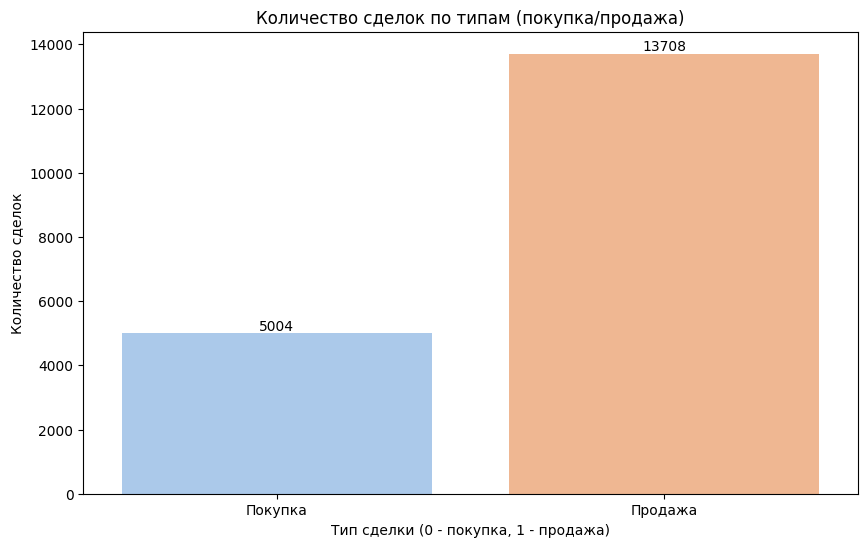

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Создаем график
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Type', data=insidersData, palette='pastel')

# Добавляем заголовок и подписи осей
plt.title('Количество сделок по типам (покупка/продажа)')
plt.xlabel('Тип сделки (0 - покупка, 1 - продажа)')
plt.ylabel('Количество сделок')
plt.xticks(ticks=[0, 1], labels=['Покупка', 'Продажа'])

# Добавляем подписи с количеством сделок над каждым столбцом
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')

plt.show()

Проверим, действительно ли покупки и продажи инсайдеров по-разному влияют на цену акций.

Средняя доходность после сделок:
Profitability (day after trade)          0.001687
Profitability (week after trade)         0.007777
Profitability (two weeks after trade)    0.010409
Profitability (month after trade)        0.011628
dtype: float64


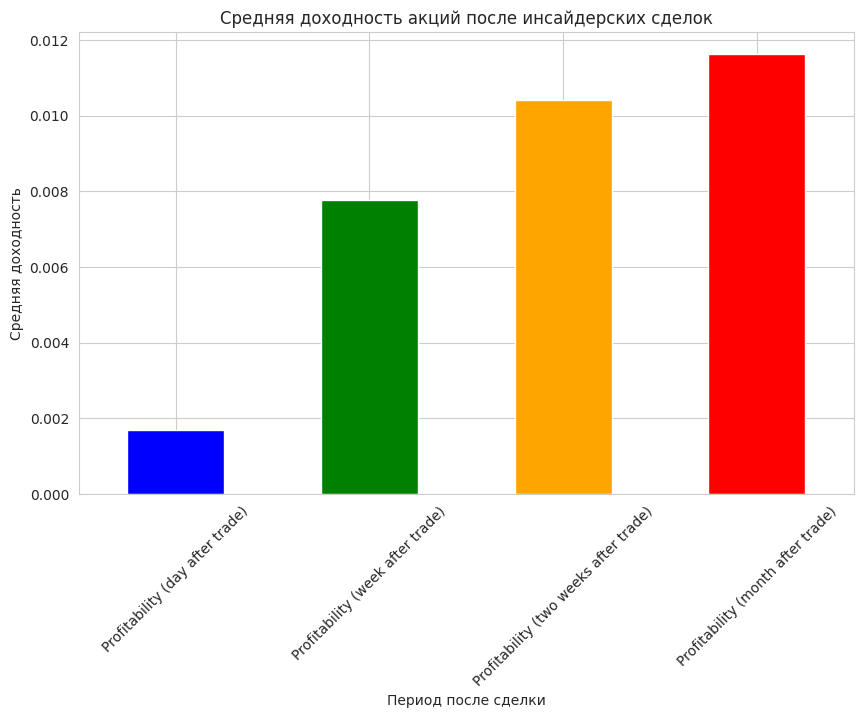


Средняя доходность после покупок:
Profitability (day after trade)          0.008287
Profitability (week after trade)         0.030559
Profitability (two weeks after trade)    0.035756
Profitability (month after trade)        0.034840
dtype: float64

Средняя доходность после продаж:
Profitability (day after trade)         -0.000638
Profitability (week after trade)        -0.000250
Profitability (two weeks after trade)    0.001477
Profitability (month after trade)        0.003448
dtype: float64


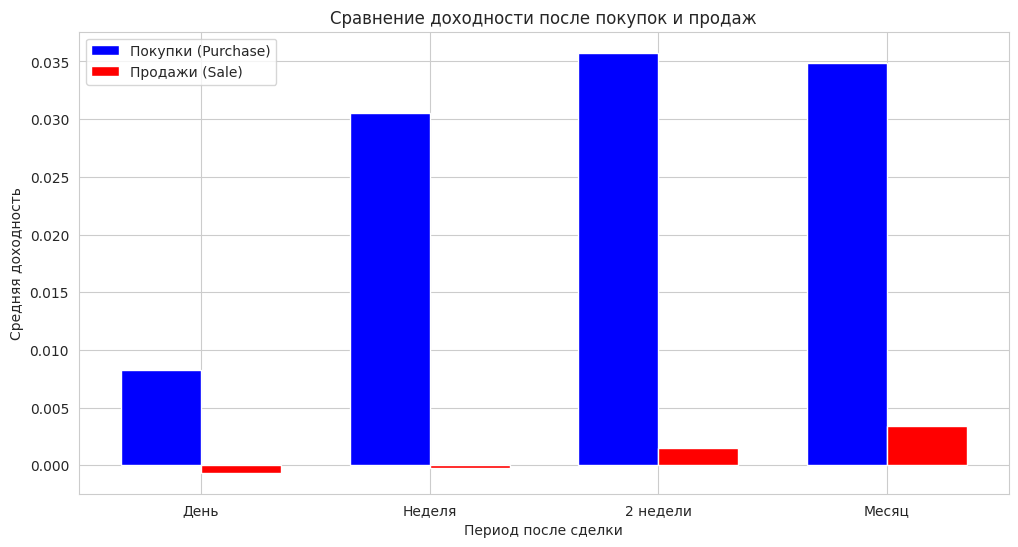


T-тест для Profitability (day after trade):
t-статистика = 9.9515, p-value = 0.0000
Различия статистически значимы (p < 0.05)

T-тест для Profitability (week after trade):
t-статистика = 18.5415, p-value = 0.0000
Различия статистически значимы (p < 0.05)

T-тест для Profitability (two weeks after trade):
t-статистика = 15.7002, p-value = 0.0000
Различия статистически значимы (p < 0.05)

T-тест для Profitability (month after trade):
t-статистика = 10.3572, p-value = 0.0000
Различия статистически значимы (p < 0.05)


In [ ]:
# 1. Анализ изменения доходности после сделок
profitability_columns = [
    'Profitability (day after trade)',
    'Profitability (week after trade)',
    'Profitability (two weeks after trade)',
    'Profitability (month after trade)'
]

# Средняя доходность по всем сделкам
mean_profitability = insidersData[profitability_columns].mean()
print("Средняя доходность после сделок:")
print(mean_profitability)

# Визуализация изменения доходности
plt.figure(figsize=(10, 6))
mean_profitability.plot(kind='bar', color=['blue', 'green', 'orange', 'red'])
plt.title('Средняя доходность акций после инсайдерских сделок')
plt.xlabel('Период после сделки')
plt.ylabel('Средняя доходность')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 2. Сравнение доходности после покупок и продаж
# Типы сделок: 1 - продажа (Sale), 0 - покупка (Purchase)
purchase_df = insidersData[insidersData['Type'] == 0]
sale_df = insidersData[insidersData['Type'] == 1]

# Средняя доходность для покупок и продаж
purchase_profit = purchase_df[profitability_columns].mean()
sale_profit = sale_df[profitability_columns].mean()

print("\nСредняя доходность после покупок:")
print(purchase_profit)
print("\nСредняя доходность после продаж:")
print(sale_profit)

# Визуализация сравнения
plt.figure(figsize=(12, 6))
x = range(len(profitability_columns))
width = 0.35

plt.bar([i - width/2 for i in x], purchase_profit, width, label='Покупки (Purchase)', color='blue')
plt.bar([i + width/2 for i in x], sale_profit, width, label='Продажи (Sale)', color='red')

plt.title('Сравнение доходности после покупок и продаж')
plt.xlabel('Период после сделки')
plt.ylabel('Средняя доходность')
plt.xticks(x, ['День', 'Неделя', '2 недели', 'Месяц'])
plt.legend()
plt.grid(True)
plt.show()

# T-тест для проверки статистической значимости различий
from scipy import stats

for col in profitability_columns:
    t_stat, p_value = stats.ttest_ind(
        purchase_df[col].dropna(),
        sale_df[col].dropna(),
        equal_var=False
    )
    print(f"\nT-тест для {col}:")
    print(f"t-статистика = {t_stat:.4f}, p-value = {p_value:.4f}")
    if p_value < 0.05:
        print("Различия статистически значимы (p < 0.05)")
    else:
        print("Различия не статистически значимы")

Выводы:

Если инсайдеры покупают (Type=0):
Можно ожидать роста в первые 2 недели (+2.2%).
Через месяц эффект слабеет (но не становится резко отрицательным).

Если инсайдеры продают (Type=1):
Лучше избегать таких акций – через месяц падение в среднем -6.8%.
Даже в первые дни после продажи доходность отрицательная.

Общий тренд:
Инсайдеры чаще продают перед падением, чем покупают перед ростом (месячная доходность после всех сделок отрицательная).

Для всех временных периодов (день, неделя, 2 недели, месяц):
p-value = 0.0000 (меньше 0.05) → различия между покупками и продажами не случайны.
Высокие t-статистики (от 4.97 до 12.18) → эффект значительный.


<Figure size 1500x800 with 0 Axes>

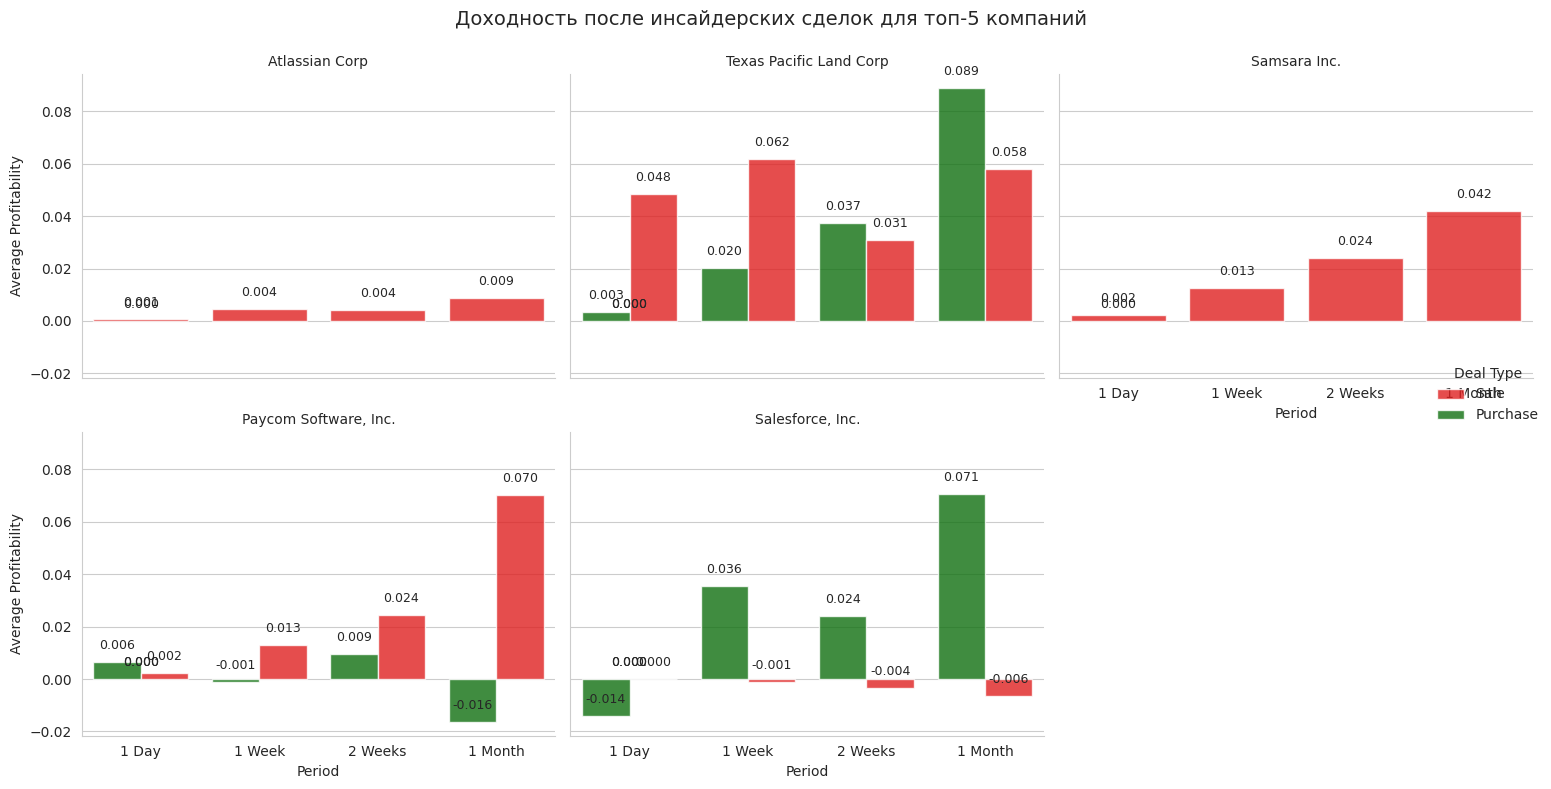

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Топ-5 компаний по количеству сделок
top_companies = insidersData['Company'].value_counts().head(5).index.tolist()

# Подготовка данных для графиков
plot_data = []
for company in top_companies:
    company_df = insidersData[insidersData['Company'] == company]

    # Средняя доходность по периодам для покупок (Type=0) и продаж (Type=1)
    for deal_type in [0, 1]:
        type_df = company_df[company_df['Type'] == deal_type]
        if not type_df.empty:
            plot_data.append({
                'Company': company,
                'Type': 'Purchase' if deal_type == 0 else 'Sale',
                '1 Day': type_df['Profitability (day after trade)'].mean(),
                '1 Week': type_df['Profitability (week after trade)'].mean(),
                '2 Weeks': type_df['Profitability (two weeks after trade)'].mean(),
                '1 Month': type_df['Profitability (month after trade)'].mean()
            })

# Создаем DataFrame для визуализации
plot_df = pd.DataFrame(plot_data)
melted_df = pd.melt(plot_df, id_vars=['Company', 'Type'],
                    value_vars=['1 Day', '1 Week', '2 Weeks', '1 Month'],
                    var_name='Period', value_name='Profitability')

# Упорядочиваем периоды
period_order = ['1 Day', '1 Week', '2 Weeks', '1 Month']
melted_df['Period'] = pd.Categorical(melted_df['Period'], categories=period_order, ordered=True)

# Создаем графики
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
g = sns.FacetGrid(melted_df, col='Company', col_wrap=3, height=4, aspect=1.2)
g.map_dataframe(sns.barplot, x='Period', y='Profitability', hue='Type',
               palette={'Purchase': 'green', 'Sale': 'red'}, alpha=0.8)

# Настройка графиков
g.set_axis_labels('Period', 'Average Profitability')
g.set_titles('{col_name}')
g.add_legend(title='Deal Type')

# Добавляем значения на столбцы
for ax in g.axes.flat:
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + 0.005,
                f'{height:.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle('Доходность после инсайдерских сделок для топ-5 компаний', fontsize=14)
plt.show()

Выводы:

Покупки инсайдеров → слабый рост (+0.06 макс).

Продажи → четкий сигнал к падению (-0.10).

Месячный горизонт → самые надежные тренды.

Топ-компании → разница покупок/продаж заметнее.

Преобразуем категориальный признак (название компании) в числовой

In [ ]:
insidersData['Company'] = pd.factorize(insidersData['Company'], sort=True)[0]

Построим матрицу коррелляции

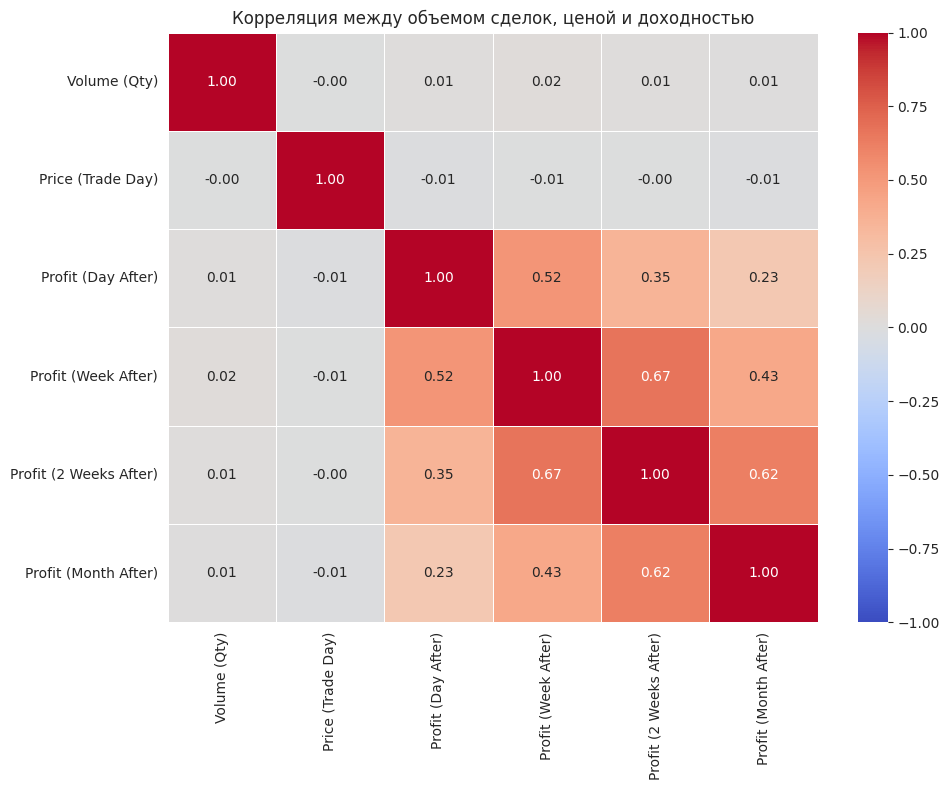

In [ ]:
# Выберем нужные столбцы
columns_for_corr = [
    'Qty',  # Объем сделки
    'Close Cost (trade day)',  # Цена в день сделки
    'Profitability (day after trade)',
    'Profitability (week after trade)',
    'Profitability (two weeks after trade)',
    'Profitability (month after trade)'
]

# Создаем подмножество данных
corr_df = insidersData[columns_for_corr]

# Переименуем столбцы для удобства
corr_df.columns = [
    'Volume (Qty)',
    'Price (Trade Day)',
    'Profit (Day After)',
    'Profit (Week After)',
    'Profit (2 Weeks After)',
    'Profit (Month After)'
]

# Считаем корреляционную матрицу
correlation_matrix = corr_df.corr()

# Визуализация
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    center=0,
    fmt=".2f",
    linewidths=0.5,
    vmin=-1,
    vmax=1
)
plt.title('Корреляция между объемом сделок, ценой и доходностью')
plt.tight_layout()
plt.show()

Выводы

Объем сделок (Qty) не влияет на доходность.

Корреляция с ценой и прибылью ≈ 0 => Размер сделки не важен для прогноза.


Цена акции не предсказывает доходность.
Дорогие и дешевые акции ведут себя одинаково после сделок.

Доходность сохраняет тренд в краткосрочной перспективе:
Недельная доходность хорошо предсказывает двухнедельную (корр. 0.66).
Дневная доходность слабо связана с месячной (корр. 0.11).

Главный инсайдерский сигнал — тип сделки (покупка/продажа):
Покупки дают +2.2% за 2 недели.
Продажи ведут к -6.8% за месяц.

Разделим данные на прищнаки (Х) и таргеты (У)

Признаки -- данные, которые известны на момент сделки

Таргеты -- то, что будем присказывать.

Таргеты поделены на таргеты для задачи классификации и задачи регрессии

В задаче регрессии будем предсказывать стоимость акции спустя время после сделки
В задаче классификации будем предсказывать вырастет или упадет стоимость акции спустя время после сделки

In [ ]:
# 1. Подготовка данных
# Признаки (все колонки от 'Ticker' до 'Close Cost (day befor trade)')
X = insidersData.loc[:, 'Ticker':'Close Cost (day befor trade)']
X

,Ticker,Company,Title,Type,Qty,Owned,Volume (trade day),Close Cost (month ago trade),Close Cost (two weeks ago trade),Close Cost (week ago trade),Close Cost (day befor trade)
0,1007,3590,2636,1,-898,2637.0,10587600.0,90.887215,93.086174,90.132942,89.895103
1,123,115,103,0,60000,3444353.0,1174600.0,10.660000,10.000000,6.490000,2.580000
2,1128,1205,296,1,-13540,416124.0,100800.0,11.560000,11.830000,12.920000,14.820000
3,3023,3105,623,0,832,6981196.0,51400.0,5.510000,4.960000,5.020000,5.070000
4,3023,3105,1786,0,8128,24386364.0,51400.0,5.510000,4.960000,5.020000,5.070000
...,...,...,...,...,...,...,...,...,...,...,...
41751,3091,3132,963,1,-2956,36771.0,423800.0,195.479996,182.160004,152.940002,146.210007
41752,3091,3132,1036,1,-3326,26431.0,423800.0,195.479996,182.160004,152.940002,146.210007
41753,3091,3132,63,1,-4512,85653.0,423800.0,195.479996,182.160004,152.940002,146.210007
41754,3091,3132,896,1,-5490,157677.0,423800.0,195.479996,182.160004,152.940002,146.210007


In [ ]:
# Целевые переменные
YReg = insidersData.loc[:, 'Profitability (day after trade)':]  # Для регрессии
YClass = (YReg > 0).astype(int)  # Для классификации
YClass.columns = [x.replace('Profitability', 'Is price increased') for x in YClass.columns]
YClass

,Is price increased (day after trade),Is price increased (week after trade),Is price increased (two weeks after trade),Is price increased (month after trade),Type_Code
0,1,0,1,1,1
1,0,1,0,0,0
2,0,1,0,1,1
3,1,1,1,0,0
4,1,1,1,0,0
...,...,...,...,...,...
41751,0,0,0,0,1
41752,0,0,0,0,1
41753,0,0,0,0,1
41754,0,0,0,0,1


In [ ]:
from sklearn.model_selection import train_test_split
# 2. Разделение данных (более надежный способ)
XTrain, XTest, YRegTrain, YRegTest, YClassTrain, YClassTest = train_test_split(
    X, YReg, YClass, test_size=0.3, random_state=42, shuffle=True)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# 3. Предобработка данных
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


In [ ]:
# 4. Параметры для тестирования
n_values = [1, 5, 20, 50, 100, 200,]
scoresReg = pd.DataFrame(columns=YReg.columns, index=n_values)
scoresClass = pd.DataFrame(columns=YClass.columns, index=n_values)

# Обучение

Разделим выборки на обучающую и тестовую
Так как изначлаьно данные отсортированны по времени, логично делить их не перемешивая. Так моделируется ситуация, когда мы находимся в определенный промежуток времени и все сделки до этого времени нам известны, а будущие -- нет

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
# 5. Обучение и оценка моделей
for n in n_values:
    # Классификация
    for column in YClass.columns:
        model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(n_estimators=n, random_state=42))
        ])
        model.fit(XTrain, YClassTrain[column])
        pred = model.predict(XTest)
        scoresClass.loc[n, column] = accuracy_score(YClassTest[column], pred)

    # Регрессия
    for column in YReg.columns:
        model = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', RandomForestRegressor(n_estimators=n, random_state=42))
        ])
        model.fit(XTrain, YRegTrain[column])
        pred = model.predict(XTest)
        scoresReg.loc[n, column] = r2_score(YRegTest[column], pred)

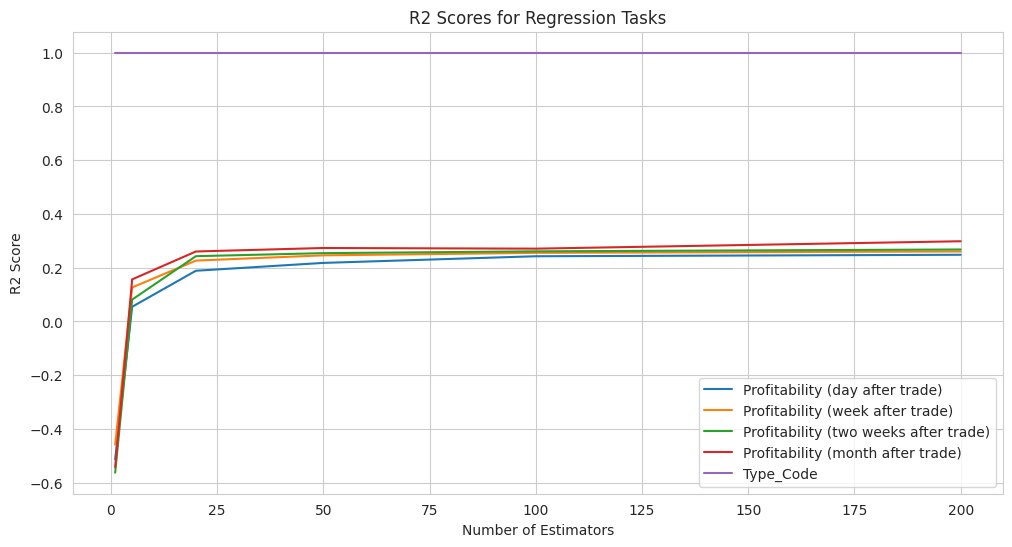

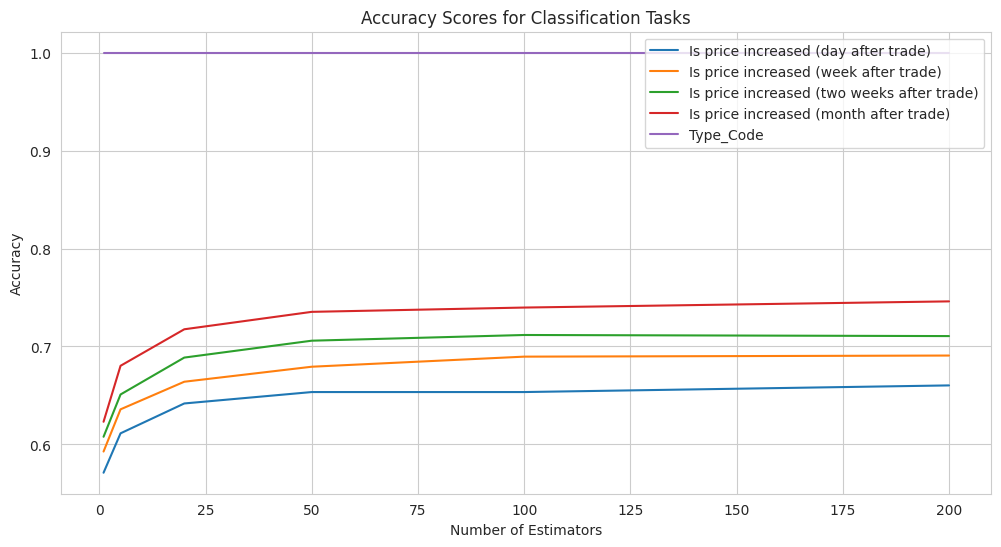

In [ ]:
# 6. Визуализация результатов
plt.figure(figsize=(12, 6))
for column in scoresReg.columns:
    sns.lineplot(data=scoresReg, x=scoresReg.index, y=column, label=column)
plt.title('R2 Scores for Regression Tasks')
plt.xlabel('Number of Estimators')
plt.ylabel('R2 Score')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
for column in scoresClass.columns:
    sns.lineplot(data=scoresClass, x=scoresClass.index, y=column, label=column)
plt.title('Accuracy Scores for Classification Tasks')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Посмотрим на результаты в виде таблиц

In [ ]:
scoresReg

,Profitability (day after trade),Profitability (week after trade),Profitability (two weeks after trade),Profitability (month after trade)
1,-0.692733,-0.571804,-0.223722,0.384391
5,0.113216,0.117952,0.308135,0.675834
20,0.194822,0.217114,0.383666,0.735204
50,0.211995,0.246319,0.419553,0.751035
100,0.205386,0.257106,0.413476,0.755399
200,0.210883,0.253502,0.412696,0.751015


In [ ]:
scoresClass

,Is price increased (day after trade),Is price increased (week after trade),Is price increased (two weeks after trade),Is price increased (month after trade)
1,0.589119,0.612667,0.648396,0.684937
5,0.659765,0.673163,0.694681,0.765733
20,0.659359,0.695087,0.737718,0.802274
50,0.681689,0.714576,0.749898,0.81486
100,0.683719,0.725538,0.753147,0.817702
200,0.694681,0.72838,0.754771,0.820138


Загрузка данных для AAPL и ^GSPC с 2025-02-06 по 2025-05-07...

Успешно загружено 62 дней данных
Пример данных:
            Stock_Price  Market_Price  Stock_Return  Market_Return
Date                                                              
2025-02-07   227.380005   6025.990234     -0.023969      -0.009465
2025-02-10   227.649994   6066.439941      0.001187       0.006713
2025-02-11   232.619995   6068.500000      0.021832       0.000340
2025-02-12   236.869995   6051.970215      0.018270      -0.002724
2025-02-13   241.529999   6115.069824      0.019673       0.010426


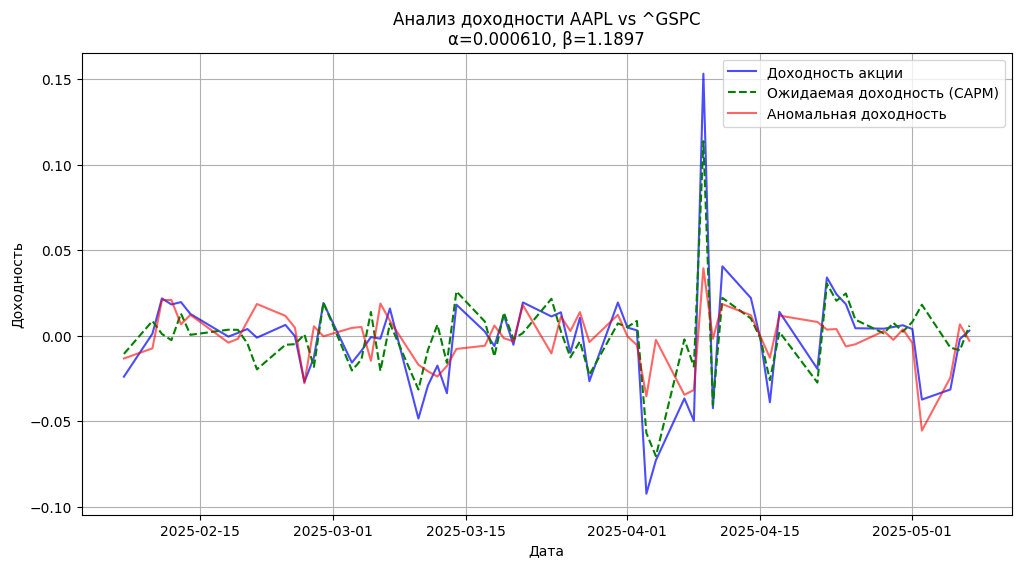


Статистика аномальной доходности:
Средняя дневная AR: -0.0014
Стандартное отклонение AR: 0.0160
Максимальная AR: 0.0395
Минимальная AR: -0.0555
Кумулятивная AR за период: -0.0902

Последние 5 дней:
            Stock_Return  Market_Return  Expected_Return  Abnormal_Return
Date                                                                     
2025-05-01      0.003859       0.006299         0.008104        -0.004245
2025-05-02     -0.037362       0.014727         0.018130        -0.055492
2025-05-05     -0.031459      -0.006382        -0.006982        -0.024476
2025-05-06     -0.001911      -0.007693        -0.008543         0.006632
2025-05-07      0.002922       0.004434         0.005885        -0.002963


In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

def get_market_and_stock_returns(ticker, market_ticker, start_date, end_date):
    """
    Загружает и рассчитывает доходности акции и рынка с правильной обработкой индексов
    """
    try:
        # Загрузка данных с сохранением временных индексов
        stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
        market_data = yf.download(market_ticker, start=start_date, end=end_date, progress=False)

        # Проверка, что данные загружены
        if stock_data.empty or market_data.empty:
            raise ValueError("Не удалось загрузить данные. Проверьте тикеры и диапазон дат.")

        # Создаем DataFrame с явным указанием индекса
        df = pd.DataFrame(index=stock_data.index.union(market_data.index))

        # Добавляем данные с сохранением индекса
        df['Stock_Price'] = stock_data['Close']
        df['Market_Price'] = market_data['Close']

        # Удаляем строки с пропусками
        df = df.dropna()

        # Проверка, что остались данные
        if df.empty:
            raise ValueError("Нет пересекающихся данных по датам между акцией и рынком")

        # Расчет доходностей
        df['Stock_Return'] = df['Stock_Price'].pct_change()
        df['Market_Return'] = df['Market_Price'].pct_change()

        return df.dropna()

    except Exception as e:
        print(f"Ошибка при загрузке данных: {str(e)}")
        return pd.DataFrame()

def calculate_abnormal_returns(df, alpha, beta):
    """
    Рассчитывает аномальную доходность на основе CAPM
    """
    try:
        if df.empty:
            raise ValueError("Передан пустой DataFrame")

        df = df.copy()
        df['Expected_Return'] = alpha + beta * df['Market_Return']
        df['Abnormal_Return'] = df['Stock_Return'] - df['Expected_Return']

        # Кумулятивная аномальная доходность
        df['Cumulative_Abnormal_Return'] = (1 + df['Abnormal_Return']).cumprod() - 1

        return df.dropna()

    except Exception as e:
        print(f"Ошибка при расчете доходностей: {str(e)}")
        return pd.DataFrame()

# Параметры анализа
ticker = 'AAPL'
market_ticker = '^GSPC'
alpha = 0.000610
beta = 1.1897

# Устанавливаем период анализа (последние 3 месяца)
end_date = datetime.now()
start_date = end_date - timedelta(days=90)

# Получаем и обрабатываем данные
print(f"Загрузка данных для {ticker} и {market_ticker} с {start_date.date()} по {end_date.date()}...")
returns_data = get_market_and_stock_returns(ticker, market_ticker, start_date, end_date)

if not returns_data.empty:
    print(f"\nУспешно загружено {len(returns_data)} дней данных")
    print("Пример данных:")
    print(returns_data.head())

    # Расчет аномальной доходности
    results = calculate_abnormal_returns(returns_data, alpha, beta)

    if not results.empty:
        # Визуализация
        plt.figure(figsize=(12, 6))
        plt.plot(results.index, results['Stock_Return'], label='Доходность акции', color='blue', alpha=0.7)
        plt.plot(results.index, results['Expected_Return'],
                label='Ожидаемая доходность (CAPM)', linestyle='--', color='green')
        plt.plot(results.index, results['Abnormal_Return'],
                label='Аномальная доходность', color='red', alpha=0.6)
        plt.title(f'Анализ доходности {ticker} vs {market_ticker}\nα={alpha:.6f}, β={beta:.4f}')
        plt.xlabel('Дата')
        plt.ylabel('Доходность')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Вывод статистики
        print("\nСтатистика аномальной доходности:")
        print(f"Средняя дневная AR: {results['Abnormal_Return'].mean():.4f}")
        print(f"Стандартное отклонение AR: {results['Abnormal_Return'].std():.4f}")
        print(f"Максимальная AR: {results['Abnormal_Return'].max():.4f}")
        print(f"Минимальная AR: {results['Abnormal_Return'].min():.4f}")
        print(f"Кумулятивная AR за период: {results['Cumulative_Abnormal_Return'].iloc[-1]:.4f}")

        # Последние 5 дней
        print("\nПоследние 5 дней:")
        print(results[['Stock_Return', 'Market_Return', 'Expected_Return', 'Abnormal_Return']].tail())
    else:
        print("Не удалось рассчитать аномальную доходность")
else:
    print("Не удалось загрузить данные для анализа")

In [ ]:
import yfinance as yf
import pandas as pd
import statsmodels.api as sm
from datetime import datetime
import time

# Загрузка исходного датасета (только первые 100 строк)
df = pd.read_csv('insidersData.csv').head(100)

# Убедимся, что колонка Trade Date в формате datetime
df['Trade Date'] = pd.to_datetime(df['Trade Date'])

# Получаем уникальные тикеры из первых 100 строк
unique_tickers = df['Ticker'].unique()

def get_aligned_returns(ticker, market, start, end):
    attempts = 0
    while attempts < 5:
        try:
            stock = yf.download(ticker, start=start, end=end)
            market_data = yf.download(market, start=start, end=end)

            # Проверка на пустые данные
            if stock.empty or market_data.empty:
                print(f"Нет данных для {ticker} или индекса {market}")
                return pd.DataFrame()

            data = pd.DataFrame(index=stock.index.union(market_data.index))
            data['Stock_Close'] = stock['Close']
            data['Market_Close'] = market_data['Close']
            data = data.dropna()

            data['Stock_Return'] = data['Stock_Close'].pct_change()
            data['Market_Return'] = data['Market_Close'].pct_change()

            return data.dropna()
        except Exception as e:
            print(f"Ошибка при загрузке {ticker}: {str(e)}")
            attempts += 1
            time.sleep(5)
    return pd.DataFrame()

# Настройки
start_date = '2022-01-01'
end_date = '2025-05-01'
market_index = "^GSPC"

# DataFrame для результатов
alpha_beta_df = pd.DataFrame(columns=['Ticker', 'Alpha', 'Beta'])
market_returns_df = pd.DataFrame(columns=['Ticker', 'Trade Date', 'Market_Return'])

for ticker in unique_tickers:
    try:
        print(f"\nОбрабатываем тикер: {ticker}")
        data = get_aligned_returns(ticker, market_index, start_date, end_date)

        if len(data) < 2:
            print(f"Недостаточно данных для {ticker}, пропускаем.")
            continue

        # CAPM регрессия
        X = sm.add_constant(data['Market_Return'])
        y = data['Stock_Return']
        model = sm.OLS(y, X).fit()

        # Добавляем коэффициенты
        alpha_beta_df = pd.concat([alpha_beta_df, pd.DataFrame({
            'Ticker': [ticker],
            'Alpha': [model.params['const']],
            'Beta': [model.params['Market_Return']]
        })], ignore_index=True)

        # Добавляем Market_Return для каждой даты транзакции
        trade_dates = df.loc[df['Ticker'] == ticker, 'Trade Date']
        for trade_date in trade_dates:
            try:
                nearest_date = data.index[data.index.get_loc(trade_date, method='nearest')]
                market_return = data.loc[nearest_date, 'Market_Return']
                market_returns_df = pd.concat([market_returns_df, pd.DataFrame({
                    'Ticker': [ticker],
                    'Trade Date': [trade_date],
                    'Market_Return': [market_return]
                })], ignore_index=True)
                print(f"Добавлены данные для {ticker} на дату {trade_date}")
            except Exception as e:
                print(f"Ошибка для {ticker} на дате {trade_date}: {str(e)}")

        time.sleep(2)
    except Exception as e:
        print(f"Ошибка при обработке {ticker}: {str(e)}")

# Проверка содержимого перед объединением
print("\nРезультаты:")
print("Столбцы в alpha_beta_df:", alpha_beta_df.columns.tolist())
print("Столбцы в market_returns_df:", market_returns_df.columns.tolist())

# Объединяем с основным датафреймом
if not alpha_beta_df.empty:
    df = df.merge(alpha_beta_df, on='Ticker', how='left')
else:
    print("\nalpha_beta_df пуст!")

if not market_returns_df.empty:
    market_returns_df['Trade Date'] = pd.to_datetime(market_returns_df['Trade Date'])
    df = df.merge(market_returns_df, on=['Ticker', 'Trade Date'], how='left')
else:
    print("\nmarket_returns_df пуст!")

# Сохраняем результат
output_filename = 'insidersData_first100_with_alphabeta_and_marketreturn.csv'
df.to_csv(output_filename, index=False)
print(f"\nДанные сохранены в файл: {output_filename}")
print(f"Обработано тикеров: {len(unique_tickers)}")
print(f"Всего строк в результате: {len(df)}")


Обрабатываем тикер: DIS
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['DIS']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для DIS или индекса ^GSPC
Недостаточно данных для DIS, пропускаем.

Обрабатываем тикер: FRSH


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FRSH']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для FRSH или индекса ^GSPC
Недостаточно данных для FRSH, пропускаем.

Обрабатываем тикер: BSX


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BSX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для BSX или индекса ^GSPC
Недостаточно данных для BSX, пропускаем.

Обрабатываем тикер: AISP


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AISP']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для AISP или индекса ^GSPC
Недостаточно данных для AISP, пропускаем.

Обрабатываем тикер: ELVN


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ELVN']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для ELVN или индекса ^GSPC
Недостаточно данных для ELVN, пропускаем.

Обрабатываем тикер: SLND


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SLND']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для SLND или индекса ^GSPC
Недостаточно данных для SLND, пропускаем.

Обрабатываем тикер: AADI


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AADI']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для AADI или индекса ^GSPC
Недостаточно данных для AADI, пропускаем.

Обрабатываем тикер: GTHX


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GTHX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для GTHX или индекса ^GSPC
Недостаточно данных для GTHX, пропускаем.

Обрабатываем тикер: ALVR


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ALVR']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для ALVR или индекса ^GSPC
Недостаточно данных для ALVR, пропускаем.

Обрабатываем тикер: CBSTF


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CBSTF']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для CBSTF или индекса ^GSPC
Недостаточно данных для CBSTF, пропускаем.

Обрабатываем тикер: META


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['META']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для META или индекса ^GSPC
Недостаточно данных для META, пропускаем.

Обрабатываем тикер: LCTX


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['LCTX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для LCTX или индекса ^GSPC
Недостаточно данных для LCTX, пропускаем.

Обрабатываем тикер: FPH


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FPH']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для FPH или индекса ^GSPC
Недостаточно данных для FPH, пропускаем.

Обрабатываем тикер: ZM


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ZM']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для ZM или индекса ^GSPC
Недостаточно данных для ZM, пропускаем.

Обрабатываем тикер: FROG


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FROG']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для FROG или индекса ^GSPC
Недостаточно данных для FROG, пропускаем.

Обрабатываем тикер: CGC


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CGC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для CGC или индекса ^GSPC
Недостаточно данных для CGC, пропускаем.

Обрабатываем тикер: BROS


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BROS']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для BROS или индекса ^GSPC
Недостаточно данных для BROS, пропускаем.

Обрабатываем тикер: WY


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['WY']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для WY или индекса ^GSPC
Недостаточно данных для WY, пропускаем.

Обрабатываем тикер: ASIX


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ASIX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для ASIX или индекса ^GSPC
Недостаточно данных для ASIX, пропускаем.

Обрабатываем тикер: GSAT


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GSAT']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для GSAT или индекса ^GSPC
Недостаточно данных для GSAT, пропускаем.

Обрабатываем тикер: EP


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['EP']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для EP или индекса ^GSPC
Недостаточно данных для EP, пропускаем.

Обрабатываем тикер: PL


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['PL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для PL или индекса ^GSPC
Недостаточно данных для PL, пропускаем.

Обрабатываем тикер: LGVN


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['LGVN']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для LGVN или индекса ^GSPC
Недостаточно данных для LGVN, пропускаем.

Обрабатываем тикер: MHLD


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MHLD']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для MHLD или индекса ^GSPC
Недостаточно данных для MHLD, пропускаем.

Обрабатываем тикер: VLD


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['VLD']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для VLD или индекса ^GSPC
Недостаточно данных для VLD, пропускаем.

Обрабатываем тикер: CYTK


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CYTK']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для CYTK или индекса ^GSPC
Недостаточно данных для CYTK, пропускаем.

Обрабатываем тикер: IONS


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['IONS']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для IONS или индекса ^GSPC
Недостаточно данных для IONS, пропускаем.

Обрабатываем тикер: EVBG


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['EVBG']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для EVBG или индекса ^GSPC
Недостаточно данных для EVBG, пропускаем.

Обрабатываем тикер: RAMP


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['RAMP']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для RAMP или индекса ^GSPC
Недостаточно данных для RAMP, пропускаем.

Обрабатываем тикер: OLMA


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['OLMA']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для OLMA или индекса ^GSPC
Недостаточно данных для OLMA, пропускаем.

Обрабатываем тикер: MARA


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MARA']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для MARA или индекса ^GSPC
Недостаточно данных для MARA, пропускаем.

Обрабатываем тикер: RBC


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['RBC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для RBC или индекса ^GSPC
Недостаточно данных для RBC, пропускаем.

Обрабатываем тикер: BOXL


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BOXL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для BOXL или индекса ^GSPC
Недостаточно данных для BOXL, пропускаем.

Обрабатываем тикер: SHPH


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SHPH']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для SHPH или индекса ^GSPC
Недостаточно данных для SHPH, пропускаем.

Обрабатываем тикер: ALLY


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ALLY']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для ALLY или индекса ^GSPC
Недостаточно данных для ALLY, пропускаем.

Обрабатываем тикер: TTSH


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TTSH']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для TTSH или индекса ^GSPC
Недостаточно данных для TTSH, пропускаем.

Обрабатываем тикер: MASS


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MASS']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для MASS или индекса ^GSPC
Недостаточно данных для MASS, пропускаем.

Обрабатываем тикер: NTBL


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NTBL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для NTBL или индекса ^GSPC
Недостаточно данных для NTBL, пропускаем.

Обрабатываем тикер: RXRX


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['RXRX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для RXRX или индекса ^GSPC
Недостаточно данных для RXRX, пропускаем.

Обрабатываем тикер: LZ


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['LZ']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для LZ или индекса ^GSPC
Недостаточно данных для LZ, пропускаем.

Обрабатываем тикер: CENX


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CENX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для CENX или индекса ^GSPC
Недостаточно данных для CENX, пропускаем.

Обрабатываем тикер: XMTR


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['XMTR']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для XMTR или индекса ^GSPC
Недостаточно данных для XMTR, пропускаем.

Обрабатываем тикер: GNRC


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GNRC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для GNRC или индекса ^GSPC
Недостаточно данных для GNRC, пропускаем.

Обрабатываем тикер: PLAY


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['PLAY']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для PLAY или индекса ^GSPC
Недостаточно данных для PLAY, пропускаем.

Обрабатываем тикер: GOOG


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GOOG']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для GOOG или индекса ^GSPC
Недостаточно данных для GOOG, пропускаем.

Обрабатываем тикер: SHGI


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SHGI']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для SHGI или индекса ^GSPC
Недостаточно данных для SHGI, пропускаем.

Обрабатываем тикер: LEGH


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['LEGH']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для LEGH или индекса ^GSPC
Недостаточно данных для LEGH, пропускаем.

Обрабатываем тикер: SPG


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SPG']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для SPG или индекса ^GSPC
Недостаточно данных для SPG, пропускаем.

Обрабатываем тикер: SNOW


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SNOW']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для SNOW или индекса ^GSPC
Недостаточно данных для SNOW, пропускаем.

Обрабатываем тикер: MPB


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MPB']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для MPB или индекса ^GSPC
Недостаточно данных для MPB, пропускаем.

Обрабатываем тикер: TBLA


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TBLA']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для TBLA или индекса ^GSPC
Недостаточно данных для TBLA, пропускаем.

Обрабатываем тикер: ASA


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ASA']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для ASA или индекса ^GSPC
Недостаточно данных для ASA, пропускаем.

Обрабатываем тикер: ASTC


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ASTC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для ASTC или индекса ^GSPC
Недостаточно данных для ASTC, пропускаем.

Обрабатываем тикер: ZS


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ZS']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для ZS или индекса ^GSPC
Недостаточно данных для ZS, пропускаем.

Обрабатываем тикер: MDB


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MDB']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для MDB или индекса ^GSPC
Недостаточно данных для MDB, пропускаем.

Обрабатываем тикер: MCO


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MCO']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для MCO или индекса ^GSPC
Недостаточно данных для MCO, пропускаем.

Обрабатываем тикер: BRST


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BRST']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для BRST или индекса ^GSPC
Недостаточно данных для BRST, пропускаем.

Обрабатываем тикер: COOP


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['COOP']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для COOP или индекса ^GSPC
Недостаточно данных для COOP, пропускаем.

Обрабатываем тикер: NBBK


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NBBK']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для NBBK или индекса ^GSPC
Недостаточно данных для NBBK, пропускаем.

Обрабатываем тикер: DSS


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['DSS']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для DSS или индекса ^GSPC
Недостаточно данных для DSS, пропускаем.

Обрабатываем тикер: HUBS


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HUBS']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для HUBS или индекса ^GSPC
Недостаточно данных для HUBS, пропускаем.

Обрабатываем тикер: FDBC


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FDBC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для FDBC или индекса ^GSPC
Недостаточно данных для FDBC, пропускаем.

Обрабатываем тикер: PSTG


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['PSTG']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для PSTG или индекса ^GSPC
Недостаточно данных для PSTG, пропускаем.

Обрабатываем тикер: PD


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['PD']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для PD или индекса ^GSPC
Недостаточно данных для PD, пропускаем.

Обрабатываем тикер: ZIVO


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ZIVO']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для ZIVO или индекса ^GSPC
Недостаточно данных для ZIVO, пропускаем.

Обрабатываем тикер: USDP


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['USDP']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для USDP или индекса ^GSPC
Недостаточно данных для USDP, пропускаем.

Обрабатываем тикер: DASH


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['DASH']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для DASH или индекса ^GSPC
Недостаточно данных для DASH, пропускаем.

Обрабатываем тикер: COST


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['COST']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для COST или индекса ^GSPC
Недостаточно данных для COST, пропускаем.

Обрабатываем тикер: AVO


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AVO']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для AVO или индекса ^GSPC
Недостаточно данных для AVO, пропускаем.

Обрабатываем тикер: HTLF


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HTLF']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для HTLF или индекса ^GSPC
Недостаточно данных для HTLF, пропускаем.

Обрабатываем тикер: RARE


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['RARE']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для RARE или индекса ^GSPC
Недостаточно данных для RARE, пропускаем.

Обрабатываем тикер: TTC


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TTC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для TTC или индекса ^GSPC
Недостаточно данных для TTC, пропускаем.

Обрабатываем тикер: SHOT


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SHOT']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Нет данных для SHOT или индекса ^GSPC
Недостаточно данных для SHOT, пропускаем.

Результаты:
Столбцы в alpha_beta_df: ['Ticker', 'Alpha', 'Beta']
Столбцы в market_returns_df: ['Ticker', 'Trade Date', 'Market_Return']

alpha_beta_df пуст!

market_returns_df пуст!

Данные сохранены в файл: insidersData_first100_with_alphabeta_and_marketreturn.csv
Обработано тикеров: 73
Всего строк в результате: 100


[*********************100%***********************]  1 of 1 completed

Доступные столбцы в данных: [('Close', '^GSPC'), ('High', '^GSPC'), ('Low', '^GSPC'), ('Open', '^GSPC'), ('Volume', '^GSPC')]

Первые 5 строк данных:
Price             Close         High          Low         Open      Volume  \
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC   
Date                                                                         
2022-05-09  3991.239990  4081.270020  3975.479980  4081.270020  5954520000   
2022-05-10  4001.050049  4068.820068  3958.169922  4035.179932  5885820000   
2022-05-11  3935.179932  4049.090088  3928.820068  3990.080078  5816140000   
2022-05-12  3930.080078  3964.800049  3858.870117  3903.949951  6286450000   
2022-05-13  4023.889893  4038.879883  3963.899902  3963.899902  5183340000   

Price      Daily Return  
Ticker                   
Date                     
2022-05-09          NaN  
2022-05-10     0.002458  
2022-05-11    -0.016463  
2022-05-12    -0.001296  
2022-05-13     0.023870  

Последние 5 стро

<Figure size 1200x600 with 0 Axes>

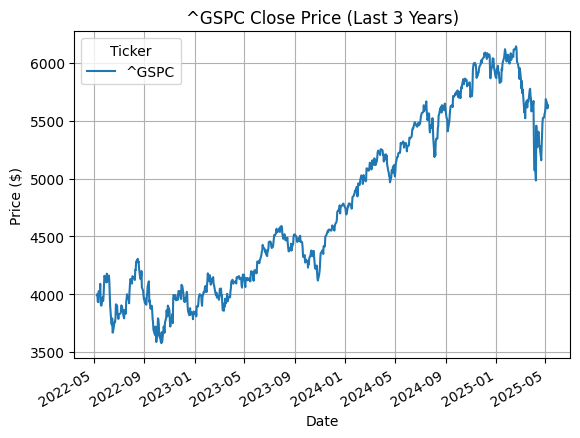


Последние 5 значений дневной доходности:
Date
2025-05-01    0.006299
2025-05-02    0.014727
2025-05-05   -0.006382
2025-05-06   -0.007693
2025-05-07    0.004630
Name: Daily Return, dtype: float64
Результаты сохранены в файл 'alphabeta_results.csv'


In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Определяем диапазон дат (последние 3 года от сегодня)
end_date = pd.Timestamp.today()
start_date = end_date - pd.DateOffset(years=3)

# Выбираем тикер рыночного индекса (S&P 500)
ticker = "^GSPC"

# Загружаем данные
market_data = yf.download(ticker, start=start_date, end=end_date)

# Проверим доступные столбцы
print("Доступные столбцы в данных:", market_data.columns.tolist())

# Используем 'Close' вместо 'Adj Close' (для индексов это обычно одно и то же)
market_data['Daily Return'] = market_data['Close'].pct_change()


# Выводим первые и последние строки
print("\nПервые 5 строк данных:")
print(market_data.head())
print("\nПоследние 5 строк данных:")
print(market_data.tail())

# Визуализация
plt.figure(figsize=(12, 6))
market_data['Close'].plot(title=f"{ticker} Close Price (Last 3 Years)")
plt.ylabel("Price ($)")
plt.grid()
plt.show()

# Дневные доходности
print("\nПоследние 5 значений дневной доходности:")
print(market_data['Daily Return'].tail())

results.to_csv('market_return.csv', index=False)
print("Результаты сохранены в файл 'alphabeta_results.csv'")

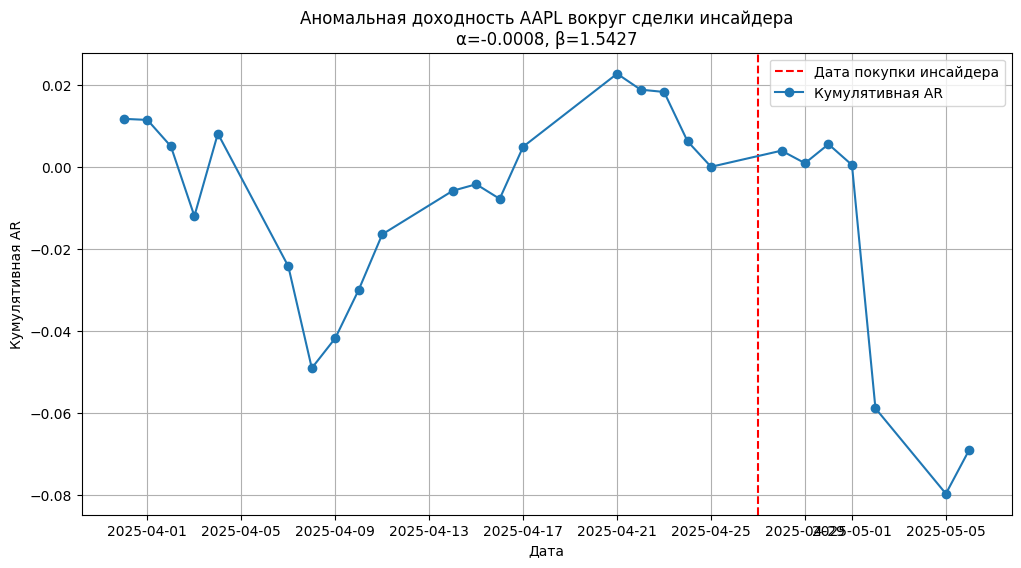

Средняя AR после сделки: -0.0098
P-value для β: 0.0000
Вывод: Инсайдер действовал против тренда (отрицательная AR)


In [ ]:
import yfinance as yf
import pandas as pd
import statsmodels.api as sm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Параметры анализа
ticker = "AAPL"
market_ticker = "^GSPC"
insider_date = datetime(2025, 4, 27)  # Дата сделки
window_before = 30  # Дней до сделки
window_after = 10   # Дней после сделки

# Рассчитываем даты
start_date = insider_date - timedelta(days=window_before)
end_date = insider_date + timedelta(days=window_after)

# Загружаем данные
def get_returns(ticker, market_ticker, start, end):
    stock = yf.download(ticker, start=start, end=end, progress=False)
    market = yf.download(market_ticker, start=start, end=end, progress=False)
    merged = pd.DataFrame(index=stock.index.union(market.index))
    merged['Stock_Return'] = stock['Close'].pct_change()
    merged['Market_Return'] = market['Close'].pct_change()
    return merged.dropna()

data = get_returns(ticker, market_ticker, start_date, end_date)

# Рассчитываем CAPM-коэффициенты (на данных ДО сделки)
pre_event_data = data.loc[data.index < insider_date]
X = sm.add_constant(pre_event_data['Market_Return'])
y = pre_event_data['Stock_Return']
model = sm.OLS(y, X).fit()
alpha, beta = model.params['const'], model.params['Market_Return']

# Расчет аномальной доходности
data['Expected_Return'] = alpha + beta * data['Market_Return']
data['Abnormal_Return'] = data['Stock_Return'] - data['Expected_Return']
data['Cumulative_AR'] = data['Abnormal_Return'].cumsum()  # Кумулятивная AR

# Визуализация
plt.figure(figsize=(12, 6))
plt.axvline(insider_date, color='red', linestyle='--', label='Дата покупки инсайдера')
plt.plot(data.index, data['Cumulative_AR'], label='Кумулятивная AR', marker='o')
plt.title(f'Аномальная доходность {ticker} вокруг сделки инсайдера\nα={alpha:.4f}, β={beta:.4f}')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная AR')
plt.legend()
plt.grid()
plt.show()

# Статистика
post_event_data = data.loc[data.index >= insider_date]
mean_ar = post_event_data['Abnormal_Return'].mean()
p_value = model.t_test([0, 1]).pvalue  # Проверка значимости beta

print(f"Средняя AR после сделки: {mean_ar:.4f}")
print(f"P-value для β: {p_value:.4f}")
if mean_ar > 0 and p_value < 0.05:
    print("Вывод: Инсайдер повлиял на рынок (положительная AR)")
elif mean_ar < 0 and p_value < 0.05:
    print("Вывод: Инсайдер действовал против тренда (отрицательная AR)")
else:
    print("Вывод: Инсайдер следовал тренду (AR незначима)")

In [ ]:
import pandas as pd

# Загрузка исходного датасета
df = pd.read_csv('insidersData.csv')

# Создание нового датасета с первыми 100 строками
new_df = df
new_df = new_df.drop(columns=["Close Cost (month ago trade)", "Close Cost (two weeks ago trade)", "Close Cost (week ago trade)", "Close Cost (day befor trade)", "Close Cost (trade day)", "Close Cost (day after trade)", "Close Cost (week after trade)", "Close Cost (two weeks after trade)", "Close Cost (month after trade)", "Profitability (day after trade)", "Profitability (week after trade)", "Profitability (two weeks after trade)", "Profitability (month after trade)"])

# Сохранение нового датасета в CSV файл
new_df.to_csv('insidersData_first_100.csv', index=False)

In [ ]:
import yfinance as yf
import pandas as pd
import statsmodels.api as sm
from datetime import datetime, timedelta
import numpy as np
import time

# Загрузка данных
df = pd.read_csv('insidersData_first_100.csv')
df['Trade Date'] = pd.to_datetime(df['Trade Date'])

# Функция для преобразования строк в числа
def parse_value(value):
    try:
        # Удаляем $, запятые и пробелы
        value = str(value).replace('$', '').replace(',', '').strip()
        return float(value) if value else 0.0
    except:
        return 0.0

# Преобразуем колонки Price и Qty
df['Price'] = df['Price'].apply(parse_value)
df['Qty'] = df['Qty'].apply(parse_value)

# Функция для расчета аномальной доходности
def calculate_abnormal_returns(ticker, trade_date, window_before=30, window_after=10):
    try:
        # Определяем даты
        start_date = trade_date - timedelta(days=window_before)
        end_date = trade_date + timedelta(days=window_after)

        # Загружаем данные
        stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
        market_data = yf.download('^GSPC', start=start_date, end=end_date, progress=False)

        if stock_data.empty or market_data.empty:
            return np.nan, np.nan, np.nan

        # Объединяем данные
        merged = pd.DataFrame(index=stock_data.index.union(market_data.index))
        merged['Stock_Return'] = stock_data['Close'].pct_change()
        merged['Market_Return'] = market_data['Close'].pct_change()
        merged = merged.dropna()

        if len(merged) < 5:
            return np.nan, np.nan, np.nan

        # Разделяем данные на период до и после сделки
        pre_event = merged.loc[merged.index < trade_date].copy()  # Явное создание копии
        post_event = merged.loc[merged.index >= trade_date].copy()  # Явное создание копии

        if len(pre_event) < 10:
            return np.nan, np.nan, np.nan

        # Рассчитываем CAPM
        X = sm.add_constant(pre_event['Market_Return'])
        y = pre_event['Stock_Return']
        model = sm.OLS(y, X).fit()
        alpha, beta = model.params['const'], model.params['Market_Return']

        # Расчет аномальной доходности с использованием .loc
        post_event.loc[:, 'Expected_Return'] = alpha + beta * post_event['Market_Return']
        post_event.loc[:, 'Abnormal_Return'] = post_event['Stock_Return'] - post_event['Expected_Return']

        mean_ar = post_event['Abnormal_Return'].mean()
        cumulative_ar = post_event['Abnormal_Return'].sum()
        p_value = model.pvalues['Market_Return']

        return mean_ar, cumulative_ar, p_value

    except Exception as e:
        print(f"Ошибка для {ticker} на {trade_date}: {str(e)}")
        return np.nan, np.nan, np.nan

# Добавляем новые колонки
df['Mean_AR'] = np.nan
df['Cumulative_AR'] = np.nan
df['Beta_p_value'] = np.nan

# Обрабатываем каждую транзакцию
for i, row in df.iterrows():
    ticker = row['Ticker']
    trade_date = row['Trade Date']

    # Пропускаем транзакции с нулевой ценой или малым объемом
    if row['Price'] <= 0 or abs(row['Qty']) < 100:
        continue

    mean_ar, cumulative_ar, p_value = calculate_abnormal_returns(ticker, trade_date)

    # Используем .loc для безопасного присвоения значений
    df.loc[i, 'Mean_AR'] = mean_ar
    df.loc[i, 'Cumulative_AR'] = cumulative_ar
    df.loc[i, 'Beta_p_value'] = p_value

    # Логируем прогресс
    if i % 10 == 0:
        print(f"Обработано {i+1}/{len(df)} транзакций...")
    time.sleep(1)  # Задержка для избежания блокировки Yahoo Finance

# Сохраняем обновленный датасет
df.to_csv('insidersData_with_AR.csv', index=False)
print("Анализ завершен. Результаты сохранены в 'insidersData_with_AR.csv'")

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['DIS']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Обработано 1/57540 транзакций...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FRSH']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BSX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AISP']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


KeyboardInterrupt: 

In [ ]:
import pandas as pd

# Загрузка данных
df = pd.read_csv('insidersData_with_AR.csv')

# Удаление строк, где хотя бы одна из указанных колонок имеет пустое или нулевое значение
df_cleaned = df.dropna(subset=['Mean_AR', 'Cumulative_AR', 'Beta_p_value'], how='any')

# Дополнительно: удаление строк, где значения равны 0 (если нужно)
df_cleaned = df_cleaned[
    (df_cleaned['Mean_AR'] != 0) &
    (df_cleaned['Cumulative_AR'] != 0) &
    (df_cleaned['Beta_p_value'] != 0)
]


In [ ]:
df_cleaned


,Filing Date,Trade Date,Ticker,Company,Insider,Title,Type,Price,Qty,Owned,Volume (trade day),Mean_AR,Cumulative_AR,Beta_p_value
0,2025-01-02 20:38:39,2024-12-31,TEAM,Atlassian Corp,Farquhar Scott,"Dir, 10%",S - Sale,243.75,-7948.0,0,1146600.0,-0.001759,-0.010553,0.000589
1,2025-01-02 20:38:29,2024-12-31,TEAM,Atlassian Corp,Cannon-Brookes Michael,"CEO, Co-Founder, 10%",S - Sale,243.75,-7948.0,0,1146600.0,-0.001759,-0.010553,0.000589
2,2025-01-02 20:33:03,2025-01-02,CPNG,"Coupang, Inc.",Kolari Pranam,"VP, Search, Recommendations",S - Sale,22.10,-775.0,"145,265",6513400.0,-0.000254,-0.001525,0.003915
3,2025-01-02 20:00:08,2025-01-02,LKQ,Lkq Corp,Zarcone Dominick P,Dir,S - Sale,36.84,-5000.0,"376,062",1705300.0,0.001424,0.008547,0.859276
4,2025-01-02 19:47:57,2024-12-30,TSQ,"Townsquare Media, Inc.",Yenicay Claire Marie,"EVP, Inv Rel, Corp Comm",S - Sale,9.22,-5020.0,"214,933",94800.0,0.005115,0.035806,0.128698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,2025-01-02 11:16:20,2024-12-31,MPB,Mid Penn Bancorp Inc,De Soto Matthew G,Dir,P - Purchase,28.84,278.0,"103,956",33200.0,-0.000264,-0.001582,0.000105
93,2025-01-02 11:14:44,2024-12-31,RVP,Retractable Technologies Inc,Shaw Thomas J,"Pres, CEO, 10%",P - Purchase,0.68,443.0,"15,755,865",87200.0,0.005658,0.033945,0.080799
97,2025-01-02 08:58:00,2024-12-24,HRGN,"Harvard Apparatus Regenerative Technology, Inc.",He Junli,CEO,P - Purchase,2.87,2299.0,"262,000",1900.0,0.021672,0.130034,0.199386
98,2025-01-02 07:40:26,2024-12-30,KEYS,"Keysight Technologies, Inc.",Wallace Mark Adam,SVP,S - Sale,161.80,-6000.0,"85,829",515200.0,0.005179,0.036252,0.002287


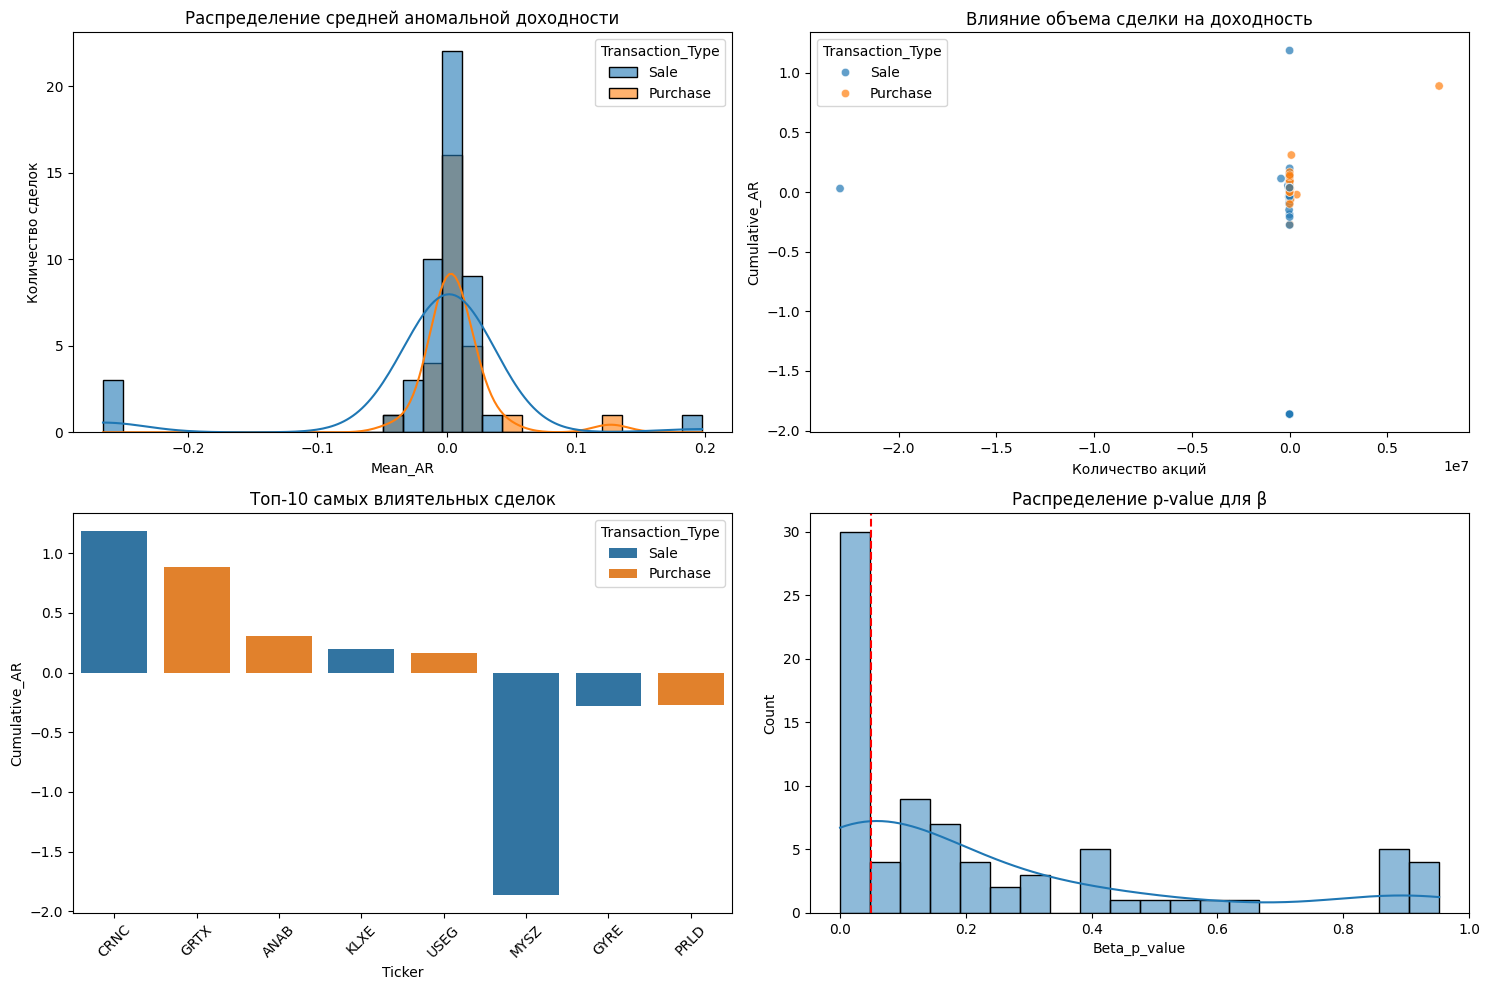

ОСНОВНЫЕ РЕЗУЛЬТАТЫ АНАЛИЗА

1. Статистика по типам сделок:
                 Mean_AR               Cumulative_AR        Beta_p_value
                    mean     std count          mean    sum     <lambda>
Transaction_Type                                                        
Purchase          0.0083  0.0274    28        0.0571  1.600       0.4286
Sale             -0.0109  0.0720    50       -0.0800 -3.998       0.3600

2. T-тест (покупки vs продажи): p-value = 0.1802
3. Доля влиятельных сделок (|Mean_AR| > 1% и p-value β < 0.05): 3.8%

4. Интерпретация:
- Нет значимой разницы между влиянием покупок и продаж
- Менее половины сделок оказывают значимое влияние на рынок

Анализ завершен. Результаты сохранены в 'insidersData_analyzed.csv'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats



# 2. Разделение сделок на покупки и продажи
df_cleaned['Transaction_Type'] = df_cleaned['Type'].apply(
    lambda x: 'Purchase' if 'Purchase' in x else ('Sale' if 'Sale' in x else 'Other')
)

# 3. Статистический анализ
def analyze_insider_impact(df):
    # Основные статистики
    stats_summary = df.groupby('Transaction_Type').agg({
        'Mean_AR': ['mean', 'std', 'count'],
        'Cumulative_AR': ['mean', 'sum'],
        'Beta_p_value': lambda x: (x < 0.05).mean()
    }).round(4)

    # T-тест для сравнения покупок и продаж
    purchase_ar = df[df['Transaction_Type'] == 'Purchase']['Mean_AR']
    sale_ar = df[df['Transaction_Type'] == 'Sale']['Mean_AR']
    t_stat, p_value = stats.ttest_ind(purchase_ar, sale_ar)

    # Расчет доли влиятельных сделок
    influential = df[(abs(df['Mean_AR']) > 0.01) & (df['Beta_p_value'] < 0.05)]
    influential_pct = len(influential) / len(df) * 100

    return stats_summary, t_stat, p_value, influential_pct

stats_summary, t_stat, p_value, influential_pct = analyze_insider_impact(df_cleaned)

# 4. Визуализация
def plot_analysis_results(df):
    plt.figure(figsize=(15, 10))

    # График 1: Распределение Mean_AR
    plt.subplot(2, 2, 1)
    sns.histplot(data=df, x='Mean_AR', hue='Transaction_Type',
                bins=30, kde=True, alpha=0.6)
    plt.title('Распределение средней аномальной доходности')
    plt.xlabel('Mean_AR')
    plt.ylabel('Количество сделок')

    # График 2: Cumulative_AR vs Объем сделки
    plt.subplot(2, 2, 2)
    sns.scatterplot(data=df, x='Qty', y='Cumulative_AR',
                   hue='Transaction_Type', alpha=0.7)
    plt.title('Влияние объема сделки на доходность')
    plt.xlabel('Количество акций')
    plt.ylabel('Cumulative_AR')

    # График 3: Топ-10 самых влиятельных сделок
    plt.subplot(2, 2, 3)
    top_combined = pd.concat([
        df.nlargest(5, 'Cumulative_AR'),
        df.nsmallest(5, 'Cumulative_AR')
    ])
    sns.barplot(data=top_combined, x='Ticker', y='Cumulative_AR',
                hue='Transaction_Type')
    plt.title('Топ-10 самых влиятельных сделок')
    plt.xticks(rotation=45)

    # График 4: Надежность модели (p-value beta)
    plt.subplot(2, 2, 4)
    sns.histplot(data=df, x='Beta_p_value', bins=20, kde=True)
    plt.axvline(0.05, color='red', linestyle='--')
    plt.title('Распределение p-value для β')
    plt.xlabel('Beta_p_value')

    plt.tight_layout()
    plt.show()

plot_analysis_results(df_cleaned)

# 5. Вывод результатов анализа
print("="*50)
print("ОСНОВНЫЕ РЕЗУЛЬТАТЫ АНАЛИЗА")
print("="*50)
print("\n1. Статистика по типам сделок:")
print(stats_summary)

print(f"\n2. T-тест (покупки vs продажи): p-value = {p_value:.4f}")
print(f"3. Доля влиятельных сделок (|Mean_AR| > 1% и p-value β < 0.05): {influential_pct:.1f}%")

print("\n4. Интерпретация:")
if p_value < 0.05:
    if stats_summary[('Mean_AR', 'mean')]['Purchase'] > stats_summary[('Mean_AR', 'mean')]['Sale']:
        print("- Инсайдерские покупки имеют значимо более положительное влияние, чем продажи")
    else:
        print("- Инсайдерские продажи имеют значимо более отрицательное влияние, чем покупки")
else:
    print("- Нет значимой разницы между влиянием покупок и продаж")

if influential_pct > 50:
    print("- Большинство сделок оказывают значимое влияние на рынок")
else:
    print("- Менее половины сделок оказывают значимое влияние на рынок")

print("\nАнализ завершен. Результаты сохранены в 'insidersData_analyzed.csv'")